# Ad-Hoc Code for Ablation Study Plots

This document provides the code used to generate the numerical results plots for the Cartpole hyperparameter analysis and the MountainCar training progress. Code within this notebook could be reused for future runs, however, we Ad-Hoc parsed data from tensorboard files to generates the data that is utilized below. 

Tensorboard files are quite simple to parse, the code in this notebook only makes use of the Average Trial reward tag. After extracting these values, and some structuring of the data, this document can be used to generate figures similar to ours.

In [1]:
import pickle
import json
import sys
import os

sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import stats, norm

from utils import DotDict

## Data I/O

The file loaded in below contains the data for the ablation analysis using the transition function regularization techniques. Canonical MuZero was run separately and asynchronously to this run. Results is a dictionary where keys are an unique parameter-configuration (given by config), and the values are the mean trial rewards during training for $r$ training repetitions.

In [2]:
with open('data/cp_ablation/CP_ablation.out', 'rb') as f:
    results = pickle.load(f)
    
config = DotDict.from_json('data/cp_ablation/ablation_schedule_20201203-111902.json')

In [4]:
with open('data/cp_ablation/CP_ablation_correction.out', 'rb') as f:
    results_correction = pickle.load(f)
    
config_correction = DotDict.from_json('data/cp_ablation/ablation_schedule_20210124-162049.json')

The ```normal``` and ```A0``` files differ both from eachother and to the ```results``` file; unfortunately, we parsed each file in an Ad-Hoc manner for convenient I/O and because the code respository underwent refactoring during one of the runs.

```normal``` is a dictionary with two keys, ```names``` and ```data```. The ```names``` key contains a list of names, in order, for each experiment run. The ```data``` key, then has their respective average trial results for each of the $r$ repetitions.

```A0``` is simply a numpy array that contains average trial reward trajectories over $3$ runs. 

In [5]:
# Add non-ablation study data (normal MuZero; varied over L and K)
with open('data/cp_ablation/CP_normal.out', 'rb') as f:
    normal = pickle.load(f)
    
# Add non-ablation study data (normal AlphaZero)
with open('data/cp_ablation/A0CP_ablation.out', 'rb') as f:
    A0 = pickle.load(f)

The ```mc``` data is again a dictionary, this one has as keys the run-name; which is in this case the original tensorboard eventfile path. The value of each item is the mean trial rewards during training without any repetitions $r=1$.

In [6]:
# Numerical results of MountainCar agents.
with open('data/mc_trials/MC_results.out', 'rb') as f:
    mc = pickle.load(f)

In [96]:
config

{'0': {'args': {'K': 1,
   'latent_decoder': True,
   'latent_depth': 4,
   'dynamics_penalty': 1},
  'net_args': {'latent_depth': 4, 'dynamics_penalty': 1}},
 '1': {'args': {'K': 1,
   'latent_decoder': True,
   'latent_depth': 4,
   'dynamics_penalty': 0.1},
  'net_args': {'latent_depth': 4, 'dynamics_penalty': 0.1}},
 '2': {'args': {'K': 1,
   'latent_decoder': True,
   'latent_depth': 4,
   'dynamics_penalty': 0.01},
  'net_args': {'latent_depth': 4, 'dynamics_penalty': 0.01}},
 '3': {'args': {'K': 1,
   'latent_decoder': True,
   'latent_depth': 8,
   'dynamics_penalty': 1},
  'net_args': {'latent_depth': 8, 'dynamics_penalty': 1}},
 '4': {'args': {'K': 1,
   'latent_decoder': True,
   'latent_depth': 8,
   'dynamics_penalty': 0.1},
  'net_args': {'latent_depth': 8, 'dynamics_penalty': 0.1}},
 '5': {'args': {'K': 1,
   'latent_decoder': True,
   'latent_depth': 8,
   'dynamics_penalty': 0.01},
  'net_args': {'latent_depth': 8, 'dynamics_penalty': 0.01}},
 '6': {'args': {'K': 1,
  

In [58]:
{k for k,v in config_correction.items() if v['net_args']['dynamics_penalty'] == 0}

{'11', '15', '19', '23', '3', '7'}

## Plotting

In [199]:
def plot_aggregate(data: list, bins = 20, label: list = None, v_max: int = 500): 
    probs, success_ratio, plot_data = [[] for _ in range(3)]    
    
    for v in data:
        y, x, _ = plt.hist(v.T, cumulative=True, bins=bins)
        plt.close()
    
        x = np.linspace(np.min(y), np.max(y), v.shape[-1])
        
        # Measures the number of events whether a trajectory solves the MDP at least once.
        fail_mask = v.max(axis=1) != v_max
        success_ratio.append(1 - fail_mask.astype(int).sum() / len(v))
        probs.append(1-fail_mask.astype(int))
        
        aggr = np.median(v, axis=0)
        
        plot_data.append((x, aggr))
    
    plt.figure(figsize=(8,7))
    plt.grid(linestyle='--', linewidth=1)
    
    for i, (x, y) in enumerate(plot_data):            
        if label is not None:
            plt.plot(x, y, label=label[i])
        else:
            plt.plot(x, y)
    
    if label is not None:
        plt.legend()
        
    plt.title("Median Cumulative Reward over Trials", fontsize=15)

    plt.xlabel("Trials (Number of selfplay iterations)", fontsize=13)
    plt.ylabel("Cumulative Reward", fontsize=13)
    
    return plot_data, success_ratio, probs


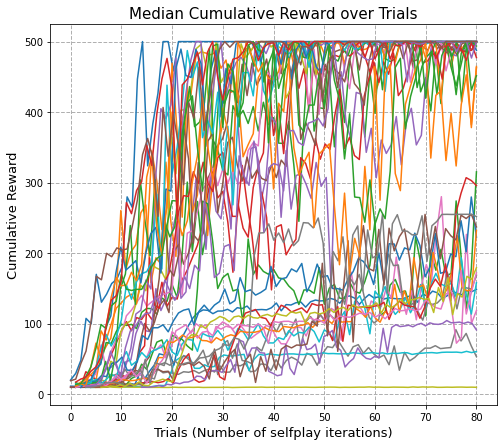

In [200]:
# Example figure of all non-aggregated ablation analysis runs.
plot_data, success, ps = plot_aggregate(list(results.values()))

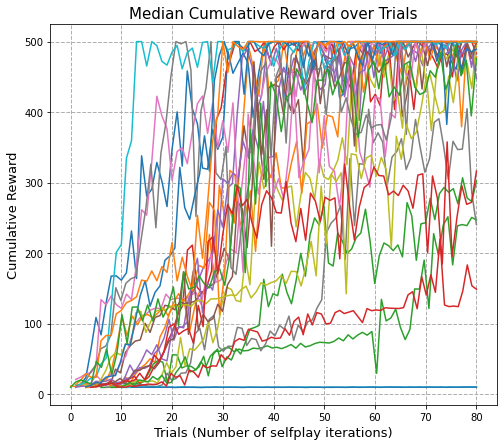

In [201]:
# Example figure of all non-aggregated ablation analysis runs.
plot_data, success, ps = plot_aggregate(list(results_correction.values()))

In [202]:
# Extract by order neat lists of hyperparameters.
K, L, dec, penalty = [[] for _ in range(4)]

for k, v in config.items():
    K.append(v.args.K)
    L.append(v.net_args.latent_depth)
    dec.append(v.args.latent_decoder)
    penalty.append(v.net_args.dynamics_penalty)
    
    
# Extract per hyperparameter K config data.
k1, k5, k10 = [[] for _ in range(3)]

for k, v in config.items():
    v.args.recursive_update(v.net_args)
  
    if v.args.K == 1:
        k1.append(v.args)
    elif v.args.K == 5:
        k5.append(v.args)
    elif v.args.K == 10:
        k10.append(v.args)

## Plot comparison over Ablations of K and Transition Regularization

In [238]:
list(config_correction.values())

[{'args': {'K': 1}, 'net_args': {'latent_depth': 4, 'dynamics_penalty': 1}},
 {'args': {'K': 1}, 'net_args': {'latent_depth': 4, 'dynamics_penalty': 0.1}},
 {'args': {'K': 1}, 'net_args': {'latent_depth': 4, 'dynamics_penalty': 0.01}},
 {'args': {'K': 1}, 'net_args': {'latent_depth': 4, 'dynamics_penalty': 0}},
 {'args': {'K': 1}, 'net_args': {'latent_depth': 8, 'dynamics_penalty': 1}},
 {'args': {'K': 1}, 'net_args': {'latent_depth': 8, 'dynamics_penalty': 0.1}},
 {'args': {'K': 1}, 'net_args': {'latent_depth': 8, 'dynamics_penalty': 0.01}},
 {'args': {'K': 1}, 'net_args': {'latent_depth': 8, 'dynamics_penalty': 0}},
 {'args': {'K': 5}, 'net_args': {'latent_depth': 4, 'dynamics_penalty': 1}},
 {'args': {'K': 5}, 'net_args': {'latent_depth': 4, 'dynamics_penalty': 0.1}},
 {'args': {'K': 5}, 'net_args': {'latent_depth': 4, 'dynamics_penalty': 0.01}},
 {'args': {'K': 5}, 'net_args': {'latent_depth': 4, 'dynamics_penalty': 0}},
 {'args': {'K': 5}, 'net_args': {'latent_depth': 8, 'dynamics

In [248]:
cor = list(results_correction.values())

kl_cor = cor[0:3] + cor[4:7] + cor[8:11] + cor[12:15] + cor[16:19] + cor[20:23]
normal_cor = list(np.asarray(cor)[[3, 7, 11, 15, 19, 23]])

[0.875, 0.75, 0.5, 0.625, 0.625, 0.625, 0.75, 0.625, 0.75, 0.375, 0.25, 0.625, 0.5, 0.375, 0.625, 0.75, 0.875, 0.75, 0.625, 1.0, 0.875, 1.0, 0.625, 0.5]


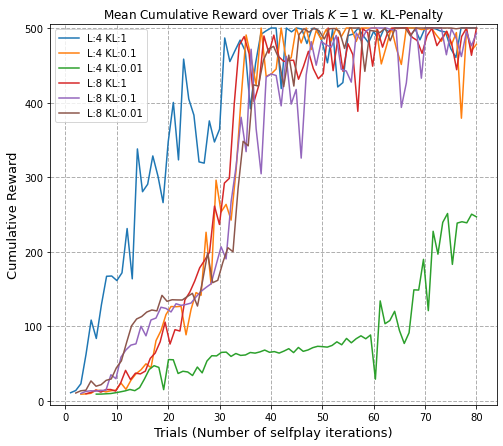

[0.875, 0.75, 0.5, 0.625, 0.625, 0.625, 0.75, 0.625, 0.75, 0.375, 0.25, 0.625, 0.5, 0.375, 0.625, 0.75, 0.875, 0.75, 0.625, 1.0, 0.875, 1.0, 0.625, 0.5]


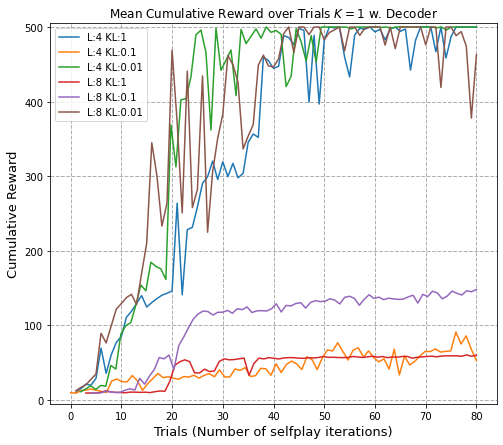

In [244]:
plot_data, k1_kl, k1_kl_p = plot_aggregate(kl_cor[0:6], bins=20, label=[f'L:{x.latent_depth} KL:{x.dynamics_penalty}' for x in k5[:6]])
plt.title(r"Mean Cumulative Reward over Trials $K=1$ w. KL-Penalty")
print(success)
plt.ylim([-5, 505])
plt.show()

plot_data, k1_d, k1_d_p = plot_aggregate(list(results.values())[6:12], bins=20, label=[f'L:{x.latent_depth} KL:{x.dynamics_penalty}' for x in k5[6:]])
plt.title(r"Mean Cumulative Reward over Trials $K=1$ w. Decoder")
print(success)
plt.ylim([-5, 505])
plt.show()

[0.875, 0.75, 0.5, 0.625, 0.625, 0.625, 0.75, 0.625, 0.75, 0.375, 0.25, 0.625, 0.5, 0.375, 0.625, 0.75, 0.875, 0.75, 0.625, 1.0, 0.875, 1.0, 0.625, 0.5]


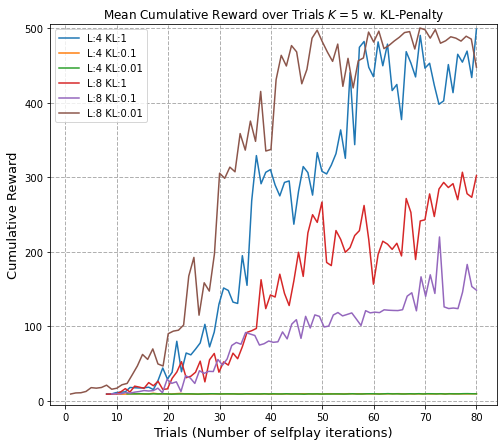

[0.875, 0.75, 0.5, 0.625, 0.625, 0.625, 0.75, 0.625, 0.75, 0.375, 0.25, 0.625, 0.5, 0.375, 0.625, 0.75, 0.875, 0.75, 0.625, 1.0, 0.875, 1.0, 0.625, 0.5]


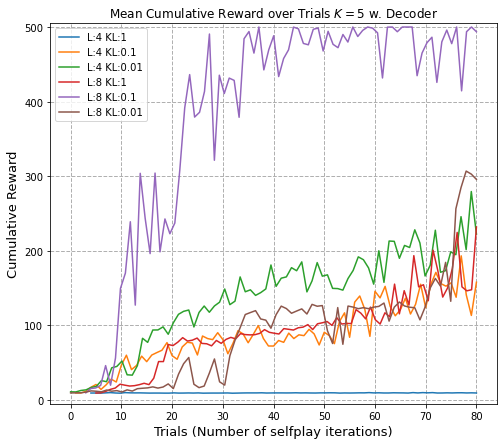

In [245]:
plot_data, k5_kl, k5_kl_p = plot_aggregate(kl_cor[6:12], bins=20, label=[f'L:{x.latent_depth} KL:{x.dynamics_penalty}' for x in k5[:6]])
plt.title(r"Mean Cumulative Reward over Trials $K=5$ w. KL-Penalty")
print(success)
plt.ylim([-5, 505])
plt.show()

plot_data, k5_d, k5_d_p = plot_aggregate(list(results.values())[18:24], bins=20, label=[f'L:{x.latent_depth} KL:{x.dynamics_penalty}' for x in k5[6:]])
plt.title(r"Mean Cumulative Reward over Trials $K=5$ w. Decoder")
print(success)
plt.ylim([-5, 505])
plt.show()

[0.875, 0.75, 0.5, 0.625, 0.625, 0.625, 0.75, 0.625, 0.75, 0.375, 0.25, 0.625, 0.5, 0.375, 0.625, 0.75, 0.875, 0.75, 0.625, 1.0, 0.875, 1.0, 0.625, 0.5]


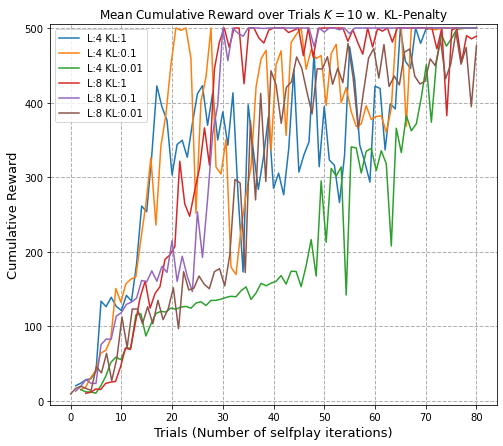

[0.875, 0.75, 0.5, 0.625, 0.625, 0.625, 0.75, 0.625, 0.75, 0.375, 0.25, 0.625, 0.5, 0.375, 0.625, 0.75, 0.875, 0.75, 0.625, 1.0, 0.875, 1.0, 0.625, 0.5]


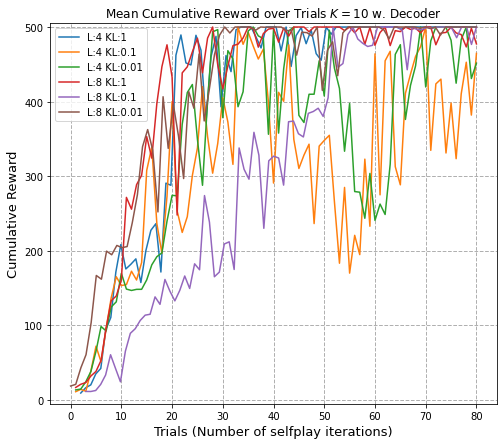

In [246]:
plot_data, k10_kl, k10_kl_p = plot_aggregate(kl_cor[12:18], bins=20, label=[f'L:{x.latent_depth} KL:{x.dynamics_penalty}' for x in k5[:6]])
plt.title(r"Mean Cumulative Reward over Trials $K=10$ w. KL-Penalty")
print(success)
plt.ylim([-5, 505])
plt.show()

plot_data, k10_d, k10_d_p = plot_aggregate(list(results.values())[30:36], bins=20, label=[f'L:{x.latent_depth} KL:{x.dynamics_penalty}' for x in k5[6:]])
plt.title(r"Mean Cumulative Reward over Trials $K=10$ w. Decoder")
print(success)
plt.ylim([-5, 505])
plt.show()

## Estimation of Success Probabilities by Comparing Means

In [211]:
# Neatly collect all success probabilities into an orderly dataframe.
df = pd.DataFrame(np.array([k1_kl, k5_kl, k10_kl, k1_d, k5_d, k10_d]).ravel('F'), columns=['success'])

df['K'] = K
df['Regularization'] = ['dec' if b else 'kl' for b in dec]
df['L'] = L
df['Penalty'] = penalty

df.head()

,success,K,Regularization,L,Penalty
0,0.875,1,dec,4,1.00
1,0.750,1,dec,4,0.10
2,0.875,1,dec,4,0.01
3,0.750,1,dec,8,1.00
4,0.125,1,dec,8,0.10


In [226]:
for k, g in df.groupby(['Regularization', 'L']):
    print(k)
    print(g.iloc[g.success.argmax()])
    print(g)
    print()

('dec', 4)
success              1
K                   10
Regularization     dec
L                    4
Penalty           0.01
Name: 26, dtype: object
    success   K Regularization  L  Penalty
0     0.875   1            dec  4     1.00
1     0.750   1            dec  4     0.10
2     0.875   1            dec  4     0.01
12    0.500   5            dec  4     1.00
13    0.250   5            dec  4     0.10
14    0.625   5            dec  4     0.01
24    0.625  10            dec  4     1.00
25    0.375  10            dec  4     0.10
26    1.000  10            dec  4     0.01

('dec', 8)
success              1
K                    1
Regularization     dec
L                    8
Penalty           0.01
Name: 5, dtype: object
    success   K Regularization  L  Penalty
3     0.750   1            dec  8     1.00
4     0.125   1            dec  8     0.10
5     1.000   1            dec  8     0.01
15    1.000   5            dec  8     1.00
16    0.250   5            dec  8     0.10
17    0.875 

In [218]:
grouped = df.groupby(['Regularization', 'Penalty'])
logodds = lambda x: np.log(x / (1 - x + 0.01))  # 0.01 is an epsilon term for numerical stability.
sigmoid = lambda x: 1 / (1+np.exp(-x)) - 0.01   # -0.01 to correct for epsilon term

vals = list()
for k, g in grouped:
    lo = logodds(g.success)
    
    # 60% CIs
    CI = np.asarray([sigmoid(lo.mean() - lo.std() / np.sqrt(8)), 
                     sigmoid(lo.mean() + lo.std() / np.sqrt(8))])
    vals.append((sigmoid(lo.mean()), CI))
    
means, CIs = list(zip(*vals))

In [161]:
normal['names']
aggr = np.asarray(cor)[[3, 7, 11, 15, 19, 23]]  #normal['data'][[3, 4, 5, 11, 12]]

data = np.any(aggr == 500, axis=-1).mean(axis=1)
lo = logodds(data)

m = sigmoid(lo.mean())
CI = [sigmoid(lo.mean() - lo.std() / np.sqrt(8)), sigmoid(lo.mean() + lo.std() / np.sqrt(8))]

## CartPole Confidence Intervals for MDP Solve Success

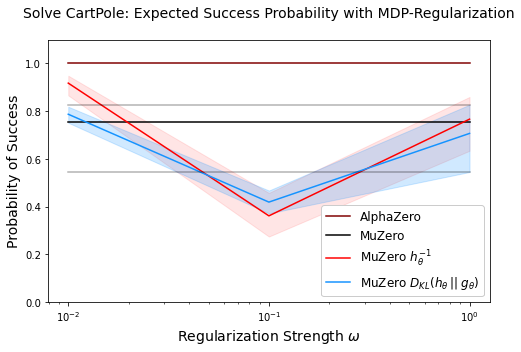

In [165]:
plt.figure(figsize=(7, 5))

plt.plot([0.01, 1], [1, 1], c='maroon', label="AlphaZero")
plt.plot([], [], label='MuZero', c='black')
plt.plot([0.01, 1.], [m, m], linestyle='-', c='black')
plt.plot([0.01, 0.1, 1.], means[:3], c='red', label=r'MuZero $h_{\theta}^{-1}$')
plt.plot([0.01, 0.1, 1.], means[3:], c=u'#1593FF', label=r'MuZero $D_{KL}(h_{\theta} \: \vert \vert \: g_{\theta})$')

plt.plot([0.01, 1.], [CI[0]] * 2, alpha=0.3, zorder=3, color='black')
plt.plot([0.01, 1.], [CI[1]] * 2, alpha=0.3, zorder=3, color='black')
plt.fill_between([0.01, 0.1, 1.], *list(zip(*CIs[:3])), color='red', alpha=0.1)
plt.fill_between([0.01, 0.1, 1.], *list(zip(*CIs[3:])), color=u'#1593FF', alpha=0.2)

plt.xlabel("Regularization Strength $\omega$", fontsize=14)
plt.ylabel("Probability of Success", fontsize=14)
plt.title("Solve CartPole: Expected Success Probability with MDP-Regularization\n", fontsize=14)

plt.ylim([0, 1.1])
plt.xscale('log')
plt.legend(fontsize=12, loc='lower right', framealpha=1)

plt.tight_layout()

# plt.savefig("out/figures/CPRegularization_MarginalSuccess.svg", format='svg')
plt.show()

## CartPole Aggregated Training Progress

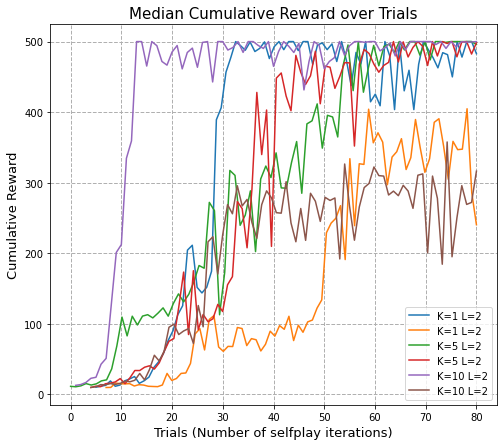

In [176]:
_ = plot_aggregate(aggr, label=[f"K={config_correction[str(i)]['args']['K']} L={2}" for i in [3, 7, 11, 15, 19, 23]])

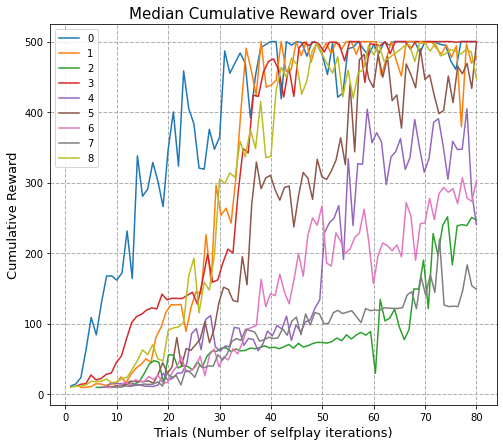

In [251]:
_= plot_aggregate(cor[:3] + cor[6:9] + cor[12:15], label=list(range(9)))

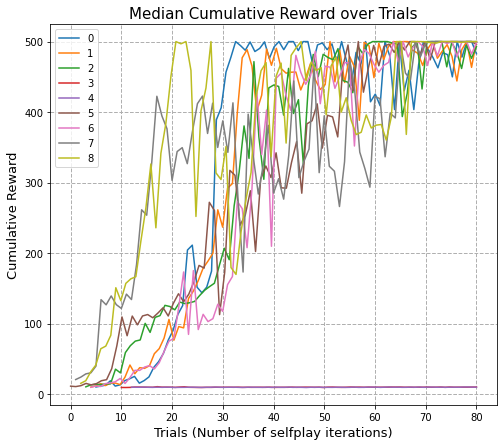

In [255]:
_= plot_aggregate(cor[3:6] + cor[9:12] + cor[15:18], label=list(range(9)))

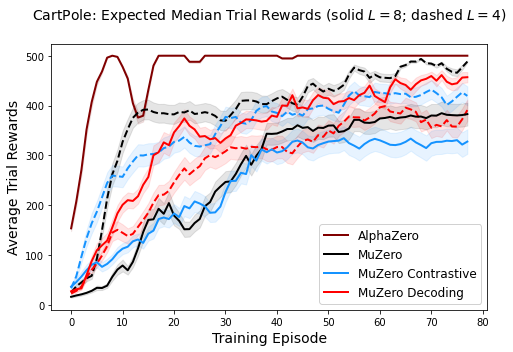

In [278]:
kl = cor[0:3] + cor[8:11] +  cor[16:19]
kl_l8 = cor[4:7] + cor[12:15] + cor[20:23]
dec = list(results.values())[0:3] + list(results.values())[12:15] + list(results.values())[24:27]
dec_l8 = list(results.values())[3:6] + list(results.values())[15:18] + list(results.values())[27:30]

plt.figure(figsize=(7, 5))

def plot_data(data, c, label, style, width=2):
    m = moving_average(np.mean(data, axis=0))
    std = moving_average(np.std(data, axis=0)) / np.sqrt(8 * 3 * 3)
    
    if label is not None:
        plt.plot(m, c=c, label=label, linestyle=style, linewidth=width)
    else:
        plt.plot(m, c=c, linestyle=style, linewidth=width)
    plt.fill_between(range(len(m)), m - std, m + std, color=c, alpha=0.1)

plot_data(A0[:,:80], c='maroon', label='AlphaZero', style='-')
plot_data(aggr[-2], c='black', label=None, style='--')
plot_data(kl_cor[0], c=u'#1593FF', label=None, style='--')
plot_data(dec[2], c='red', label=None, style='--')

plot_data(aggr[3], c='black', label='MuZero', style='-')
plot_data(kl_cor[-1], c=u'#1593FF', label='MuZero Contrastive', style='-')
plot_data(dec_l8[-1], c='red', label='MuZero Decoding', style='-')


plt.title("CartPole: Expected Median Trial Rewards (solid $L=8$; dashed $L=4$)\n", fontsize=14)
plt.ylabel(r"Average Trial Rewards", fontsize=14)
plt.xlabel("Training Episode", fontsize=14)

plt.legend(fontsize=12, framealpha=.9, loc='lower right')

plt.tight_layout()
# plt.savefig('out/figures/CPRegularization_CPProgress.svg', format='svg')
plt.show()

In [84]:
[config_correction[str(i)] for i in [3, 7, 11, 15, 19, 23]]

[{'args': {'K': 1}, 'net_args': {'latent_depth': 4, 'dynamics_penalty': 0}},
 {'args': {'K': 1}, 'net_args': {'latent_depth': 8, 'dynamics_penalty': 0}},
 {'args': {'K': 5}, 'net_args': {'latent_depth': 4, 'dynamics_penalty': 0}},
 {'args': {'K': 5}, 'net_args': {'latent_depth': 8, 'dynamics_penalty': 0}},
 {'args': {'K': 10}, 'net_args': {'latent_depth': 4, 'dynamics_penalty': 0}},
 {'args': {'K': 10}, 'net_args': {'latent_depth': 8, 'dynamics_penalty': 0}}]

In [101]:
config_correction

{'0': {'args': {'K': 1},
  'net_args': {'latent_depth': 4, 'dynamics_penalty': 1}},
 '1': {'args': {'K': 1},
  'net_args': {'latent_depth': 4, 'dynamics_penalty': 0.1}},
 '2': {'args': {'K': 1},
  'net_args': {'latent_depth': 4, 'dynamics_penalty': 0.01}},
 '3': {'args': {'K': 1},
  'net_args': {'latent_depth': 4, 'dynamics_penalty': 0}},
 '4': {'args': {'K': 1},
  'net_args': {'latent_depth': 8, 'dynamics_penalty': 1}},
 '5': {'args': {'K': 1},
  'net_args': {'latent_depth': 8, 'dynamics_penalty': 0.1}},
 '6': {'args': {'K': 1},
  'net_args': {'latent_depth': 8, 'dynamics_penalty': 0.01}},
 '7': {'args': {'K': 1},
  'net_args': {'latent_depth': 8, 'dynamics_penalty': 0}},
 '8': {'args': {'K': 5},
  'net_args': {'latent_depth': 4, 'dynamics_penalty': 1}},
 '9': {'args': {'K': 5},
  'net_args': {'latent_depth': 4, 'dynamics_penalty': 0.1}},
 '10': {'args': {'K': 5},
  'net_args': {'latent_depth': 4, 'dynamics_penalty': 0.01}},
 '11': {'args': {'K': 5},
  'net_args': {'latent_depth': 4, 

In [97]:
config

{'0': {'args': {'K': 1,
   'latent_decoder': True,
   'latent_depth': 4,
   'dynamics_penalty': 1},
  'net_args': {'latent_depth': 4, 'dynamics_penalty': 1}},
 '1': {'args': {'K': 1,
   'latent_decoder': True,
   'latent_depth': 4,
   'dynamics_penalty': 0.1},
  'net_args': {'latent_depth': 4, 'dynamics_penalty': 0.1}},
 '2': {'args': {'K': 1,
   'latent_decoder': True,
   'latent_depth': 4,
   'dynamics_penalty': 0.01},
  'net_args': {'latent_depth': 4, 'dynamics_penalty': 0.01}},
 '3': {'args': {'K': 1,
   'latent_decoder': True,
   'latent_depth': 8,
   'dynamics_penalty': 1},
  'net_args': {'latent_depth': 8, 'dynamics_penalty': 1}},
 '4': {'args': {'K': 1,
   'latent_decoder': True,
   'latent_depth': 8,
   'dynamics_penalty': 0.1},
  'net_args': {'latent_depth': 8, 'dynamics_penalty': 0.1}},
 '5': {'args': {'K': 1,
   'latent_decoder': True,
   'latent_depth': 8,
   'dynamics_penalty': 0.01},
  'net_args': {'latent_depth': 8, 'dynamics_penalty': 0.01}},
 '6': {'args': {'K': 1,
  

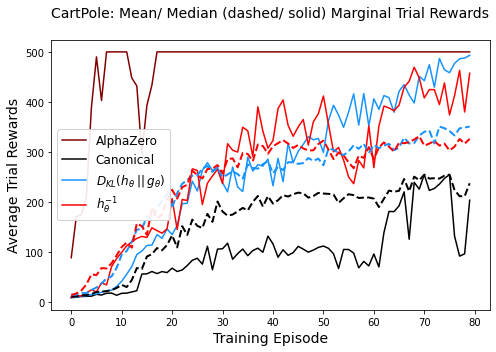

In [69]:
kl = list(results.values())[0:6] + list(results.values())[12:18] + list(results.values())[24:30]
dec = list(results.values())[6:12] + list(results.values())[18:24] + list(results.values())[30:]

plt.figure(figsize=(7, 5))

plt.plot(np.median(A0, axis=0)[:80], c='maroon', label='AlphaZero')
plt.plot(np.median(np.median(aggr, axis=1),axis=0)[:80], c='black', label='Canonical')
plt.plot(np.median(np.median(kl, axis=1),axis=0), c=u'#1593FF', label=r'$D_{KL}(h_{\theta} \: \vert \vert \: g_{\theta})$')
plt.plot(np.median(np.median(dec, axis=1),axis=0), c='red', label=r'$h_{\theta}^{-1}$')

plt.plot(np.median(np.mean(aggr, axis=1),axis=0)[:80], c='black', linestyle='--', linewidth=2)
plt.plot(np.median(np.mean(kl, axis=1),axis=0), c=u'#1593FF', linestyle='--', linewidth=2)
plt.plot(np.median(np.mean(dec, axis=1),axis=0), c='red', linestyle='--', linewidth=2)

plt.title("CartPole: Mean/ Median (dashed/ solid) Marginal Trial Rewards\n", fontsize=14)
plt.ylabel(r"Average Trial Rewards", fontsize=14)
plt.xlabel("Training Episode", fontsize=14)

plt.legend(fontsize=12, framealpha=.9, loc='center left')

plt.tight_layout()
# plt.savefig('out/figures/CPRegularization_CPProgress.svg', format='svg')
plt.show()

## MountainCar Training Progress

In [118]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

C:\Users\joery\Anaconda3\envs\tf\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


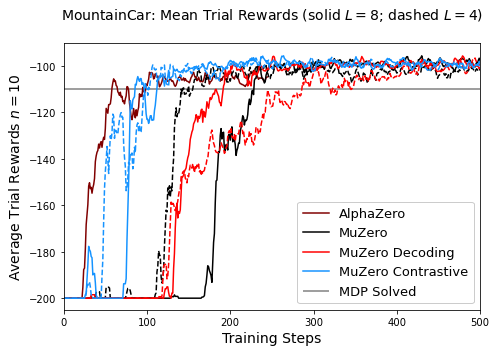

In [60]:
values = np.asarray(list(mc.values()))
labels = ['AlphaZero', r'MuZero Decoding', r'MuZero', r'MuZero Contrastive']
colors = ['maroon', 'red', 'red', 'black', 'black', u'#1593FF', u'#1593FF']
style = ['-', '--', '-', '-', '--', '--', '-']

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


plt.figure(figsize=(7, 5))

for i in [0, 2, 1, 3]:
    plt.plot([], [], c=colors[i*2], label=labels[i])

for i in [0, 4, 3, 1, 2, 6, 5]:
    plt.plot(moving_average(values[i], 5), c=colors[i], linestyle=style[i])

plt.hlines(-110, -100, 1100, color='grey', label='MDP Solved')
    
plt.title("MountainCar: Mean Trial Rewards (solid $L=8$; dashed $L=4$)\n", fontsize=14)
plt.ylabel('Average Trial Rewards $n=10$', fontsize=14)
plt.xlabel("Training Steps", fontsize=14)

plt.legend(fontsize=13, framealpha=1)

plt.xlim([0, 500])
plt.ylim([-205, -90])

plt.tight_layout()
plt.savefig('figures/MC_Progress.svg', format='svg')
plt.show()